### Import packages

In [ ]:
import pandas as pd
import numpy as np
import mlforecast
import lightgbm as lgb
from matplotlib import pyplot as plt
import optuna
import plotly_express as px
import seaborn as sns
import os
import gc
import warnings
import statsmodels.api as sm
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import re
from time import time
from datetime import datetime
import math

### Import and analyse main datasets

#### Train Dataset

In [ ]:
train = pd.read_parquet("../data/store_sales/train.parquet")
print(train.info())
print(train.describe())
display(train)

#### Test Dataset

In [ ]:
test = pd.read_parquet("../data/store_sales/test.parquet")
print(test.info())
print(test.describe())
display(test)

### Change date column to datetime

In [ ]:
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)

### Analysis of Sales in different time scales

#### Daily sales over time as a bar plot

In [ ]:
px.bar(train.groupby("date").agg({"sales": "sum"}).reset_index(), x="date", y="sales", title="Sales over time")

# should be the code for matplotlib --> to be tested

# # Group by date and sum the sales
# sales_over_time = train.groupby("date")["sales"].sum()

# # Extract the date index and sales values
# dates = sales_over_time.index
# sales = sales_over_time.values

# # Create a bar plot
# plt.figure(figsize=(10, 6))
# plt.bar(dates, sales, color='blue')

# # Set labels and title
# plt.xlabel('Date')
# plt.ylabel('Sales')
# plt.title('Sales over time')

# # Rotate x-axis labels for better readability (if necessary)
# plt.xticks(rotation=45, ha='right')

# # Show the plot
# plt.tight_layout()
# plt.show()


#### Daily sales over time as line plot

In [ ]:
px.line(train.groupby("date").agg({"sales": "sum"}).reset_index(), x="date", y="sales", title="Sales over time")

# should be the matplotlib code --> to be tested

#### Weekly sales per store

In [ ]:
weekly_sales = train.set_index("date").groupby("store_nbr").resample("W").agg({"sales": "sum"}).reset_index()
px.line(weekly_sales, x="date", y="sales", color="store_nbr", title="Weekly sales per store")

#### Monthly sales per store

In [ ]:
monthly_sales = train.set_index("date").groupby("store_nbr").resample("M").agg({"sales": "sum"}).reset_index()
px.line(monthly_sales, x="date", y="sales", color="store_nbr", title="Monthly sales per store")

#### Yearly sales summed up by store

In [ ]:
yearly_sales = train.set_index("date").groupby("store_nbr").resample("Y").agg({"sales": "sum"}).reset_index()
px.bar(yearly_sales, x="date", y="sales", title="Yearly sales per store")

### Info about stores dataset

In [ ]:
stores = pd.read_parquet("../data/store_sales/stores.parquet")
print(stores.info())
print(stores.describe())
display(stores.head())

### Merge information on stores with train data

In [ ]:
merged_train = pd.merge(train, stores, on="store_nbr")
print(merged_train.isnull().sum())
print(merged_train.info())
display(merged_train)

#### Bar plot of total sales per city

In [ ]:
px.bar(merged_train.groupby("city").agg({"sales": "sum"}).reset_index(), x="city", y="sales", title="Sales per city")

### Analysis of transactions per store per day

In [ ]:
transactions = pd.read_parquet("../data/store_sales/transactions.parquet").sort_values(["store_nbr", "date"])
transactions["date"] = pd.to_datetime(transactions.date)
print(transactions["transactions"].max)
print(transactions.info())
display(transactions)

#### Total transactions per store

In [ ]:
px.bar(transactions.groupby("store_nbr").agg({"transactions": "sum"}).reset_index(), x="store_nbr", y="transactions", title="Transactions per store")

#### Transactions per store per month

In [ ]:
transactions_temp = transactions.set_index("date").groupby("store_nbr").resample("M").agg({"transactions": "sum"}).reset_index()
px.line(transactions_temp, x="date", y="transactions", title="Transactions per store", color="store_nbr")

### Merging transactions with train

In [ ]:

transactions_merged_train = pd.merge(merged_train.sort_values(["date", "store_nbr"]), transactions, on=["date", "store_nbr"], how = "left")
print(transactions_merged_train.isnull().sum())
print(transactions_merged_train.info())

#### Filling days with 0 total sales with 0 transactions

In [ ]:
transactions_merged_train['total_sales'] = transactions_merged_train.groupby(['date', 'store_nbr'])['sales'].transform('sum')
transactions_merged_train.loc[transactions_merged_train['total_sales'] == 0, 'transactions'] = transactions_merged_train.loc[transactions_merged_train['total_sales'] == 0, 'transactions'].fillna(0)
print(f"NaN Values in Column transactions: {transactions_merged_train['transactions'].isnull().sum()}")

#### Calculating ratio between total sales and transactions on a day

In [ ]:
transactions_merged_train['sales_transactions_ratio'] = transactions_merged_train['total_sales'] / transactions_merged_train['transactions']
median_value = transactions_merged_train['sales_transactions_ratio'].median()
print(f"Median ratio between sales and transactions: {median_value}")

#### Dividing total sales on a day with NaN transaction values by median ratio

In [ ]:
transactions_merged_train['transactions'] = transactions_merged_train['transactions'].fillna(transactions_merged_train['total_sales'] / median_value)
transactions_merged_train['transactions'] = transactions_merged_train['transactions'].astype(int)
print(f"NaN Values in Column transactions: {transactions_merged_train['transactions'].isnull().sum()}")

#### Dropping helper columns

In [ ]:
transactions_merged_train = transactions_merged_train.drop(columns=["total_sales", "sales_transactions_ratio"])

### Analysis of USD to EURO Exchange rate dataset 

In [ ]:
currency_parquet = pd.read_parquet('../data/forex.parquet')
currency_parquet["date"] = pd.to_datetime(currency_parquet["date"])
print(currency_parquet.info())
display(currency_parquet)

#### Selecting USD as it is the currency of Ecuador

In [ ]:
us_currency = currency_parquet[currency_parquet['currency'] == 'USD']
print(us_currency.shape)

#### Selecting dates relevant for train dataset

In [ ]:
filtered_us_currency = us_currency[(us_currency['date'] >= transactions_merged_train["date"].min()) & (us_currency['date'] <= transactions_merged_train['date'].max())].reset_index(drop=True)
print(filtered_us_currency.shape)

#### Selecting rows with exchange rate between EUR and USD

In [ ]:
final_us_currency = filtered_us_currency[filtered_us_currency['slug'] == 'EUR/USD'].drop(['slug', "currency"], axis=1).reset_index(drop=True)
final_us_currency = final_us_currency.rename(columns={"open": "slug_eur_usd_open", "high": "slug_eur_usd_high", "low": "slug_eur_usd_low", "close": "slug_eur_usd_close"})
display(final_us_currency)

#### Merging with train dataset

In [ ]:
exchange_merged_train = transactions_merged_train.merge(final_us_currency, how="left", on="date")
print(exchange_merged_train.isnull().sum())

#### Filling missing values on weekends using forward fill

In [ ]:
exchange_merged_train = exchange_merged_train.ffill()
print(exchange_merged_train.isnull().sum())

### Analysis of General Inflation in Ecuador per year

In [ ]:
global_inflation_df = pd.read_csv('../data/global_inflation_data.csv')
print(global_inflation_df.info())
display(global_inflation_df.head())

### Selecting only values for Ecuador

In [ ]:
global_inflation_df = global_inflation_df[global_inflation_df['country_name'] == 'Ecuador']

#### Fixing Dataset by switching index/headers

In [ ]:
display(global_inflation_df.head())
global_inflation_df = global_inflation_df.transpose()
global_inflation_df = global_inflation_df.iloc[2:]
global_inflation_df = global_inflation_df.reset_index()
global_inflation_df.columns = ['date', 'inflation_ecuador']
global_inflation_df["date"] = pd.to_datetime(global_inflation_df["date"])
display(global_inflation_df.head())

#### Selecting only relevant date range

In [ ]:
global_inflation_df = global_inflation_df[(global_inflation_df['date'] >= exchange_merged_train["date"].min()) & (global_inflation_df['date'] <= exchange_merged_train['date'].max())] 
global_inflation_df = global_inflation_df.reset_index(drop=True)
display(global_inflation_df.head()) 

#### Merging dataframe with train

In [ ]:
ecuador_inflation_merged_train = exchange_merged_train.merge(global_inflation_df, how="left", on="date")
print(ecuador_inflation_merged_train.isnull().sum())
print(ecuador_inflation_merged_train.info())

#### Filling all NaN values in column with forward fill

In [ ]:
ecuador_inflation_merged_train = ecuador_inflation_merged_train.ffill()
print(f"NaN values in column inflation_ecuador: {ecuador_inflation_merged_train['inflation_ecuador'].isnull().sum()}")

### Analysis of USD inflation per month

In [ ]:
usd_inflation_df = pd.read_csv('../data/inflation_per_month.csv')
usd_inflation_df["date"] = pd.to_datetime(usd_inflation_df["DATE"])
usd_inflation_df = usd_inflation_df.drop(["DATE"], axis=1)
usd_inflation_df = usd_inflation_df.rename(columns={"CPIUFDNS_PC1": "inflation_usd"})
print(usd_inflation_df.info())
display(usd_inflation_df.head())

#### Selecting relevant date range

In [ ]:
usd_inflation_df = usd_inflation_df[(usd_inflation_df['date'] >= ecuador_inflation_merged_train["date"].min()) & (usd_inflation_df['date'] <= ecuador_inflation_merged_train['date'].max())]
usd_inflation_df = usd_inflation_df.reset_index(drop=True)
print(usd_inflation_df.info())

#### Merging dataframe with train

In [ ]:
usd_inflation_merged_train = ecuador_inflation_merged_train.merge(usd_inflation_df, how="left", on="date")
print(usd_inflation_merged_train.isnull().sum())
print(usd_inflation_merged_train.info())

#### Filling NaN values using forward fill

In [ ]:
usd_inflation_merged_train = usd_inflation_merged_train.ffill()
print(f"NaN values in column inflation_usd: {usd_inflation_merged_train['inflation_usd'].isnull().sum()}")

### Analysis of Oil Price dataset

In [ ]:
oil_price_df = pd.read_parquet('../data/store_sales/oil.parquet')
print(oil_price_df.info())
display(oil_price_df.head())

#### Converting date and renaming column

In [ ]:
oil_price_df["date"] = pd.to_datetime(oil_price_df["date"])
oil_price_df = oil_price_df.rename(columns={"dcoilwtico": "oil_price"})
print(oil_price_df.info())

#### Merging data with train

In [ ]:
oil_price_merged_train = usd_inflation_merged_train.merge(oil_price_df, how="left", on="date")
print(oil_price_merged_train.isnull().sum())
print(oil_price_merged_train.info())

#### Filling NaNs on weekends by using forward fill

In [ ]:
oil_price_merged_train = oil_price_merged_train.ffill()
print(f"NaN values in column oil_price: {oil_price_merged_train['oil_price'].isnull().sum()}")

#### Checking which dates are still missing

In [ ]:
missing_dates = oil_price_merged_train[oil_price_merged_train['oil_price'].isnull()]['date'].unique()
print(missing_dates)


#### Filling first date using backwards fill

In [ ]:
oil_price_merged_train = oil_price_merged_train.bfill()
print(f"NaN values in column oil_price: {oil_price_merged_train['oil_price'].isnull().sum()}")

### Analysis of holiday dataset

In [ ]:
holiday_dataset =  pd.read_parquet('../data/store_sales/holidays_events.parquet')
print(holiday_dataset.info())
display(holiday_dataset)

#### Drop holidays which have been shifted to another day

In [ ]:
holiday_dataset = holiday_dataset[holiday_dataset['transferred'] == False]
print(holiday_dataset.info())


### One hot encode holiday region

In [ ]:
holiday_dataset["date"] = pd.to_datetime(holiday_dataset["date"])
holiday_dataset["is_national_holiday"] = (holiday_dataset["locale"] == "National").astype(int)
holiday_dataset["is_regional_holiday"] = (holiday_dataset["locale"] == "Regional").astype(int)
holiday_dataset["is_local_holiday"] = (holiday_dataset["locale"] == "Local").astype(int)
display(holiday_dataset)


#### Merge national holidays into holiday_merged_train dataset

In [ ]:
holiday_merged_train = pd.merge(oil_price_merged_train, holiday_dataset[["date", "is_national_holiday"]], on="date", how="left")
print(holiday_merged_train.isnull().sum())
print(holiday_merged_train.info())
display(holiday_merged_train)

#### Merge regional holidays into holiday_merged_train dataset

In [ ]:
temp = holiday_dataset.copy()
temp = temp.rename(columns={"locale_name": "state"})
holiday_merged_train = pd.merge(holiday_merged_train, temp[["date", "state", "is_regional_holiday"]], on=["date", "state"], how="left")
display(holiday_merged_train)


#### Merge local holidays into holiday_merged_train dataset

In [ ]:
temp = holiday_dataset.copy()
temp = temp.rename(columns={"locale_name": "city"})
holiday_merged_train = pd.merge(holiday_merged_train, temp[["date", "city", "is_local_holiday"]], on=["date", "city"], how="left")
print(holiday_merged_train.info())
print(holiday_merged_train.isnull().sum())
display(holiday_merged_train)


#### Fill missing holiday values with 0

In [ ]:
holiday_merged_train = holiday_merged_train.fillna(0.0)
holiday_merged_train["is_national_holiday"] = holiday_merged_train["is_national_holiday"].astype(int)
holiday_merged_train["is_regional_holiday"] = holiday_merged_train["is_regional_holiday"].astype(int)
holiday_merged_train["is_local_holiday"] = holiday_merged_train["is_local_holiday"].astype(int)
print(holiday_merged_train.isnull().sum())

In [ ]:
holiday_merged_train['is_holiday'] = (holiday_merged_train['is_national_holiday'] | holiday_merged_train['is_regional_holiday'] | holiday_merged_train['is_local_holiday']).astype(int)
national_holiday_sum = holiday_merged_train['is_national_holiday'].sum()
regional_holiday_sum = holiday_merged_train['is_regional_holiday'].sum()
local_holiday_sum = holiday_merged_train['is_local_holiday'].sum()
total_holiday_sum = national_holiday_sum + regional_holiday_sum + local_holiday_sum

is_holiday_count = holiday_merged_train['is_holiday'].sum()

print("Sum of all 1 values in is_national_holiday, is_regional_holiday, and is_local_holiday together:", total_holiday_sum)
print("Count of all 1 values in is_holiday:", is_holiday_count)


### Correlation between sales and new features

In [ ]:
temp = holiday_merged_train.copy()
temp = temp[["sales", "transactions", "slug_eur_usd_open", "slug_eur_usd_high", "slug_eur_usd_low", "slug_eur_usd_close", "inflation_ecuador", "inflation_usd", "oil_price", "is_national_holiday", "is_regional_holiday", "is_local_holiday"]]
corr_df = temp.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
display(heatmap)

### Filtering out rows with unopened stores

Creating new column called open. Its 0 if the previous value in the column and the total sales on the current date are also 0, else it returns 1

In [ ]:
holiday_merged_train['total_sales'] = holiday_merged_train.groupby(['date', 'store_nbr'])['sales'].transform('sum')
holiday_merged_train['open'] = holiday_merged_train.apply(lambda x: 0 if x['total_sales'] == 0 else 1 if x.name == 0 else (0 if (x['total_sales'] == 0 and holiday_merged_train.at[x.name - 1, 'open'] == 0) else 1), axis=1)
print(holiday_merged_train.info())

### Filter out closed stores

In [ ]:
opened_merged_train = holiday_merged_train[holiday_merged_train["open"]==1]
opened_merged_train = opened_merged_train.drop(columns=["total_sales", "open"])
print(opened_merged_train.info())

### Rename columns after Nixtla standard and create unique_id column

In [ ]:
renamed_merge_train = opened_merged_train.rename(columns={"date":"ds", "sales":"y"})
renamed_merge_train["unique_id"] = renamed_merge_train["store_nbr"].astype(str) + "_" + renamed_merge_train["family"]
print(renamed_merge_train.columns)

### One-Hot-Encode categorical values

In [ ]:
encoded_merged_train = pd.get_dummies(renamed_merge_train, columns=['store_nbr', 'family', 'city', 'state'])
display(encoded_merged_train)

In [ ]:
temp_dict = {}
temp_dict["total_rows"] = opened_merged_train.shape[0]
for cluster in opened_merged_train["cluster"].unique():
    cluster_df = opened_merged_train[opened_merged_train["cluster"] == cluster]
    temp_dict[cluster] = cluster_df.shape[0]

for type in opened_merged_train["type"].unique():
    type_df = opened_merged_train[opened_merged_train["type"] == type]
    temp_dict[type] = type_df.shape[0]
    
temp_df = pd.DataFrame(temp_dict, index=["count"])
temp_df = temp_df.T
temp_df['expected_time_xgboost'] = temp_df['count'] * 0.00016029494269455797
temp_df['expected_time_decisiontree_nikl'] = temp_df['count'] * 2.4914108610565076e-06 * 25
print(temp_df['expected_time_xgboost'].sum())
print(temp_df['expected_time_decisiontree_nikl'].sum())

display(temp_df)

In [ ]:
print(7/2809653)

In [ ]:
display(encoded_merged_train["unique_id"].nunique())

print(opened_merged_train["family"].nunique())
print(opened_merged_train["store_nbr"].nunique())

# for unique_id in encoded_merged_train["unique_id"].sort_values().unique():
#     print(unique_id)

### Split dataframe by type and cluster

In [ ]:
split_dataframe_dict = {}
split_dataframe_dict["unsplit_dataframe"] = encoded_merged_train.drop(columns=["type", "cluster"])

for type_value in encoded_merged_train["type"].unique():
    split_dataframe_dict[f"type_{type_value}"] = encoded_merged_train[encoded_merged_train["type"] == type_value].drop(columns=["type", "cluster"])

for cluster_value in encoded_merged_train["cluster"].unique():
    split_dataframe_dict[f"cluster_{cluster_value}"] = encoded_merged_train[encoded_merged_train["cluster"] == cluster_value].drop(columns=["type", "cluster"])

print(len(split_dataframe_dict))

In [ ]:
best_model_per_unique_id = {}
for unique_id in encoded_merged_train["unique_id"].unique():
    best_model_per_unique_id[unique_id] = {"error": float('inf'), "prediction": pd.DataFrame(), "params": {}}

In [ ]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import joblib

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def run_forecast(train, valid, h, config, model, save="n", name_of_data=""):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1,
                                n_jobs=-1
                                )]
    elif model == "RandomForestRegressor":
        models = [RandomForestRegressor(random_state=42,
                                        n_estimators=config["n_estimators"],
                                        max_depth=config["max_depth"],
                                        min_samples_split=config["min_samples_split"],
                                        min_samples_leaf=config["min_samples_leaf"],
                                        max_features=config["max_features"],
                                        bootstrap=config["bootstrap"]
                                        )]
    elif model == "DecisionTreeRegressor":
        models = [DecisionTreeRegressor(random_state=42,
                                        max_depth=config["max_depth"],
                                        min_samples_split=config["min_samples_split"],
                                        min_samples_leaf=config["min_samples_leaf"],
                                        max_features=config["max_features"]
                                        )]
    elif model == "GradientBoostingRegressor":
        models = [GradientBoostingRegressor(random_state=42,
                                            n_estimators=config["n_estimators"],
                                            learning_rate=config["learning_rate"],
                                            max_depth=config["max_depth"],
                                            min_samples_split=config["min_samples_split"],
                                            min_samples_leaf=config["min_samples_leaf"],
                                            max_features=config["max_features"]
                                            )]
    elif model == "LinearRegressor":
        models = [LinearRegression()]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    mlfc.fit(train, max_horizon=h)
    prediction = mlfc.predict(h=h)

    merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    if save == "y":
        curr_datetime = datetime.now()
        formatted_dt = curr_datetime.strftime("%Y-%m-%d_%H-%M-%S")

        joblib.dump(mlfc, f"C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/trained_models/trained_{model}_model_{name_of_data}_{formatted_dt}.pkl")

    return merged_prediction



In [ ]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def get_feature_importance(train, valid, h, config, model):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1
                                )]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    prep_df = mlfc.preprocess(train)

    ml = models[0]
    X=prep_df.drop(columns={"y"}, axis=1)
    y=prep_df["y"]

    ml.fit(X=X, y=y)
    prediction = ml.predict(X=X)

    feature_importance = ml.feature_importances_

    merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    return merged_prediction, feature_importance
  

In [ ]:
for key, dataframe in list(split_dataframe_dict.items())[4:]:

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()
    config = {
            "n_estimators": 876,
            "learning_rate": 0.017986506325372985,
            "max_depth": 6,
            "reg_lambda": 3.1572663293571983,
            "num_leaves": 48,
            "min_data_in_leaf": 30,
            "bagging_fraction": 0.6438622663751374,
            "colsample_bytree": 0.8779957311834983,
            "lambda_l2": 5.9545729037681205,
            "lags": 56,
        }


    pred, imp = get_feature_importance(train, valid, h , config, "LGBMRegressor")
    break

display(pred)
imp.plot()


In [ ]:
def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import re
from time import time
from datetime import datetime
import math


# possible models: "XGBRegressor", "LGBMRegressor", "RandomForestRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "LinearRegressor"

model = "LGBMRegressor"

optuna.logging.set_verbosity(optuna.logging.ERROR)

error_df = pd.DataFrame({
    "unique_id": encoded_merged_train["unique_id"].unique(), 
    "rmsle": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "msle": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mse": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mae": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "r2": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mape": [float('inf')] * len(encoded_merged_train["unique_id"].unique())
    })
best_predictions_df = pd.DataFrame()
    
for key, dataframe in split_dataframe_dict.items():

    print("current dataframe: " + key)
    start = time()

    dataframe.columns = [re.sub(r'\W+', '', col) for col in dataframe.columns]

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()

    def objective(trial):
        config = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "learning_rate": trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 50),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0),
            "lags": trial.suggest_int("lags", 14, 56, step=7),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.1, 1.0)
        }

        prediction = run_forecast(train, valid, h, config, model, save="n")
        prediction.loc[prediction[model] < 0, model] = 0
        error = math.sqrt(mean_squared_log_error(prediction['y'], prediction[model]))
        
        return error

    study = optuna.create_study(direction="minimize", storage="sqlite:///../db.sqlite3", 
                                study_name=f"test2_{model}_{key}", load_if_exists=True)
    study.optimize(objective, n_trials=1, callbacks=[champion_callback])

    prediction = run_forecast(train, valid, h, study.best_params, model, save="y", name_of_data = key)


    for unique_id in prediction["unique_id"].unique():
        if study.best_value < error_df[error_df["unique_id"] == unique_id]["rmsle"].iloc[0]:
            filtered_rows = prediction[prediction["unique_id"] == unique_id]
            try:
                best_predictions_df = best_predictions_df.drop(best_predictions_df[best_predictions_df["unique_id"] == unique_id].index, axis=0)
                # error_df = error_df.drop(error_df[error_df["unique_id"] == unique_id].index, axis=0)
            except:
                print("Wasn't able to drop rows")
            best_predictions_df = pd.concat([best_predictions_df, filtered_rows], ignore_index=True)
                
            error_df.loc[error_df["unique_id"] == unique_id, "rmsle"] = study.best_value
            error_df.loc[error_df["unique_id"] == unique_id, "msle"] = pow(study.best_value, 2)
            error_df.loc[error_df["unique_id"] == unique_id, "mse"] = mean_squared_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mae"] = mean_absolute_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "r2"] = r2_score(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

    print(f"Time: {(time()-start)/60}")

                # error_dict = {}

                # error_dict["unique_id"] = unique_id
                # error_dict["cluster"] = key

                # error_dict["rmsle"] = study.best_value
                # error_dict["msle"] = pow(study.best_value, 2)
                # error_dict["mse"] = mean_squared_error(prediction['y'], prediction[model])
                # error_dict["mae"] = mean_absolute_error(prediction['y'], prediction[model])
                # error_dict["r2"] = r2_score(prediction['y'], prediction[model])
                # error_dict["mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

                # error_dict.update(study.best_params)

                # error_df = pd.concat([error_df, pd.DataFrame(error_dict, index=[0])])
    

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

best_predictions_df.to_parquet(f"C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_{model}_{formatted_datetime}_RMSLE.parquet")
error_df.to_parquet(f"C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/error_{model}_{formatted_datetime}_RMSLE.parquet")

In [ ]:
all_data = pd.DataFrame()

current_values = {"unique_id": "10_10", "cluster": "cluster_1"}
params = {"estimator":100, "depth":20, "help":True}

current_values.update(params)

all_data = pd.concat([all_data, pd.DataFrame(current_values, index=[0])])

all_data.to_parquet("all_data.parquet", index=False)

read_test = pd.read_parquet("all_data.parquet")
display(read_test)

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import re
from time import time
from datetime import datetime

# possible models: "XGBRegressor", "LGBMRegressor", "RandomForestRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "LinearRegressor"

model = "DecisionTreeRegressor"

optuna.logging.set_verbosity(optuna.logging.ERROR)

error_df = pd.DataFrame({
    "unique_id": encoded_merged_train["unique_id"].unique(), 
    "msle": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mse": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mae": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "r2": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mape": [float('inf')] * len(encoded_merged_train["unique_id"].unique())
    })
best_predictions_df = pd.DataFrame()
    
for key, dataframe in split_dataframe_dict.items():

    print("current dataframe: " + key)
    start = time()

    dataframe.columns = [re.sub(r'\W+', '', col) for col in dataframe.columns]

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()

    def objective(trial):
        config = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 50),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0),
            "lags": trial.suggest_int("lags", 14, 56, step=7),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.1, 1.0)
        }

        prediction = run_forecast(train, valid, h, config, model)
        prediction.loc[prediction[model] < 0, model] = 0
        error = mean_squared_log_error(prediction['y'], prediction[model])
        
        return error

    study = optuna.create_study(direction="minimize", storage="sqlite:////home/nikl/programming/fhdw/forecasting/ForecastingUniProject/db.sqlite3", 
                                study_name=f"SUN_{model}_{key}", load_if_exists=True)
    study.optimize(objective, n_trials=25, callbacks=[champion_callback])

    prediction = run_forecast(train, valid, h, study.best_params, model)

    for unique_id in prediction["unique_id"].unique():
        if study.best_value < error_df[error_df["unique_id"] == unique_id]["msle"].iloc[0]:
            filtered_rows = prediction[prediction["unique_id"] == unique_id]
            try:
                best_predictions_df = best_predictions_df.drop(best_predictions_df[best_predictions_df["unique_id"] == unique_id].index, axis=0)
            except:
                print("Wasn't able to drop rows")
            best_predictions_df = pd.concat([best_predictions_df, filtered_rows], ignore_index=True)

            error_df.loc[error_df["unique_id"] == unique_id, "msle"] = study.best_value
            error_df.loc[error_df["unique_id"] == unique_id, "mse"] = mean_squared_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mae"] = mean_absolute_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "r2"] = r2_score(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

    print(f"Time: {(time()-start)/60}")
    

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

best_predictions_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_{model}_{formatted_datetime}.parquet")
error_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/error_{model}_{formatted_datetime}.parquet")

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import re
from time import time
from datetime import datetime

# possible models: "XGBRegressor", "LGBMRegressor", "RandomForestRegressor", "DecisionTreeRegressor", "GradientBoostingRegressor", "LinearRegressor"

model = "LinearRegressor"

optuna.logging.set_verbosity(optuna.logging.ERROR)

error_df = pd.DataFrame({
    "unique_id": encoded_merged_train["unique_id"].unique(), 
    "msle": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mse": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mae": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "r2": [float('inf')] * len(encoded_merged_train["unique_id"].unique()),
    "mape": [float('inf')] * len(encoded_merged_train["unique_id"].unique())
    })
best_predictions_df = pd.DataFrame()
    
for key, dataframe in split_dataframe_dict.items():

    print("current dataframe: " + key)
    start = time()

    dataframe.columns = [re.sub(r'\W+', '', col) for col in dataframe.columns]

    splitting_date = "2017.08.01"
    train = dataframe[dataframe["ds"] < splitting_date]
    valid = dataframe[dataframe["ds"] >= splitting_date]
    h = valid["ds"].nunique()

    def objective(trial):
        config = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),
            "num_leaves": trial.suggest_int("num_leaves", 2, 50),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.1, 10.0),
            "lags": trial.suggest_int("lags", 14, 56, step=7),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_float("max_features", 0.1, 1.0)
        }

        prediction = run_forecast(train, valid, h, config, model)
        prediction.loc[prediction[model] < 0, model] = 0
        error = mean_squared_log_error(prediction['y'], prediction[model])
        
        return error

    study = optuna.create_study(direction="minimize", storage="sqlite:////home/nikl/programming/fhdw/forecasting/ForecastingUniProject/db.sqlite3", 
                                study_name=f"SUN_{model}_{key}", load_if_exists=True)
    study.optimize(objective, n_trials=5, callbacks=[champion_callback])

    prediction = run_forecast(train, valid, h, study.best_params, model)

    for unique_id in prediction["unique_id"].unique():
        if study.best_value < error_df[error_df["unique_id"] == unique_id]["msle"].iloc[0]:
            filtered_rows = prediction[prediction["unique_id"] == unique_id]
            try:
                best_predictions_df = best_predictions_df.drop(best_predictions_df[best_predictions_df["unique_id"] == unique_id].index, axis=0)
            except:
                print("Wasn't able to drop rows")
            best_predictions_df = pd.concat([best_predictions_df, filtered_rows], ignore_index=True)

            error_df.loc[error_df["unique_id"] == unique_id, "msle"] = study.best_value
            error_df.loc[error_df["unique_id"] == unique_id, "mse"] = mean_squared_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mae"] = mean_absolute_error(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "r2"] = r2_score(prediction['y'], prediction[model])
            error_df.loc[error_df["unique_id"] == unique_id, "mape"] = mean_absolute_percentage_error(prediction['y'], prediction[model])

    print(f"Time: {(time()-start)/60}")
    

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

best_predictions_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_{model}_{formatted_datetime}.parquet")
error_df.to_parquet(f"/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/error_{model}_{formatted_datetime}.parquet")

### LightGBM Visuals

In [ ]:
import math 
light_gbm_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_LGBMRegressor_2024-03-11_00-06-38.parquet")
light_gbm_df.loc[light_gbm_df["LGBMRegressor"] < 0, "LGBMRegressor"] = 0
print(math.sqrt(mean_squared_log_error(light_gbm_df['y'], light_gbm_df["LGBMRegressor"])))
px.scatter(light_gbm_df, x="LGBMRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for LGBMRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
light_gbm_error_df = pd.read_parquet("../results/prediction_dfs/error_LGBMRegressor_2024-03-11_00-06-38.parquet")
df_melted = light_gbm_error_df.melt(id_vars="unique_id", var_name="Error", value_name="Value")
px.bar(df_melted, x="unique_id", y="Value", color='Error', title='Balkenplot mit gestapelten Fehlern',
             labels={'Value': 'Fehlerwert', 'unique_id': 'Unique ID', 'Error': 'Fehler'})

In [ ]:
store_1_prediction = light_gbm_df[light_gbm_df["unique_id"] == "3_AUTOMOTIVE"]
#display(store_1_prediction)
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-07-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales")
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["LGBMRegressor"], mode="lines", name="Prediction")
fig.show()

# show more stores

In [244]:
lgbm = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_LGBMRegressor_2024-03-11_00-06-38.parquet")
xgb = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_XGBRegressor_2024-03-12_01-23-53.parquet")
decTree = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_DecisionTreeRegressor_2024-03-11_18-04-50.parquet")
#plot the other models as well
temp3 = encoded_merged_train[encoded_merged_train["ds"] >= "2017-07-01"]
temp1 = temp3[['ds', 'y']].groupby('ds').mean().reset_index()
tempLGBM = lgbm[['ds', 'LGBMRegressor']].groupby('ds').mean().reset_index()
tempXGB = xgb[['ds', 'XGBRegressor']].groupby('ds').mean().reset_index()
tempDecTree = decTree[['ds', 'DecisionTreeRegressor']].groupby('ds').mean().reset_index()
fig = px.line(temp1, x="ds", y="y", title="Total Sales")
fig.add_scatter(x=tempLGBM["ds"], y=tempLGBM["LGBMRegressor"], mode="lines", name="Prediction LGBM")
fig.add_scatter(x=tempXGB["ds"], y=tempXGB["XGBRegressor"], mode="lines", name="Prediction XGB")
fig.add_scatter(x=tempDecTree["ds"], y=tempDecTree["DecisionTreeRegressor"], mode="lines", name="Prediction Decision Tree")
fig.show()

### Decision Tree Visuals

In [ ]:
decision_tree_df = pd.read_parquet("/home/nikl/programming/fhdw/forecasting/ForecastingUniProject/results/prediction_dfs/prediction_DecisionTreeRegressor_2024-03-11_18-04-50.parquet")
print(math.sqrt(mean_squared_log_error(decision_tree_df['y'], decision_tree_df["DecisionTreeRegressor"])))
px.scatter(decision_tree_df, x="DecisionTreeRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for DecisionTreeRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
store_1_prediction = decision_tree_df[decision_tree_df["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["DecisionTreeRegressor"], mode="lines", name="Prediction")
fig.show()

In [ ]:
store_1_prediction = decision_tree_df[decision_tree_df["unique_id"] == "1_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "1_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-01-01" & store_1_validation["ds"] <= "2017-08-01"]

# Get the last date of the validation data
last_date = store_1_validation["ds"].max()

# Update the x-axis values of the prediction line
store_1_prediction.loc[store_1_prediction["ds"] > last_date, "ds"] = last_date

fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["DecisionTreeRegressor"], mode="lines", name="Prediction")
fig.show()


### XGBoost Visualization

In [ ]:
xgb_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_XGBRegressor_2024-03-12_01-23-53.parquet")
xgb_df.loc[xgb_df["XGBRegressor"] < 0, "XGBRegressor"] = 0
print(math.sqrt(mean_squared_log_error(xgb_df['y'], xgb_df["XGBRegressor"])))
px.scatter(xgb_df, x="XGBRegressor", y="y", title=f"Comparison of actuals vs best predicions per unique_id for XGBRegressor", opacity=0.2, trendline="ols", trendline_color_override="red")

In [ ]:
store_1_prediction = xgb_df[xgb_df["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = encoded_merged_train[encoded_merged_train["unique_id"] == "3_AUTOMOTIVE"]
store_1_validation = store_1_validation[store_1_validation["ds"] >= "2017-07-01"]
fig = px.line(store_1_validation, x="ds", y="y", title="Store 1 Sales", labels={"ds": "Date", "y": "Sales"})
fig.add_scatter(x=store_1_prediction["ds"], y=store_1_prediction["XGBRegressor"], mode="lines", name="Prediction")
fig.show()

### Optuna Study Results

#### Accessing and processing the data for Optuna

In [272]:
def get_data_from_sql(conn):
    studies_df = pd.read_sql_query("SELECT * FROM studies", conn)
    trials_df = pd.read_sql_query("SELECT * FROM trials", conn)
    trials_params_df = pd.read_sql_query("SELECT * FROM trial_params", conn)
    trials_values_df = pd.read_sql_query("SELECT * FROM trial_values", conn)

    trials_df = trials_df[trials_df["state"] == "COMPLETE"]

    #trials_df.drop(columns={"datetime_start", "datetime_complete"}, axis=1, inplace=True)

    trials_with_error_df = pd.merge(trials_df, trials_values_df, on="trial_id", how="inner")

    error_history_df = pd.merge(trials_with_error_df, studies_df, on="study_id", how="inner")

    best_trials_index = trials_with_error_df.groupby(["study_id"])["value"].idxmin()
    best_trials = trials_with_error_df.iloc[best_trials_index]

    best_trials_with_params = pd.merge(best_trials, trials_params_df, on="trial_id", how="inner")

    best_trials_with_params.drop(columns={"value_type", "distribution_json"}, axis=1, inplace=True)

    merged_df = pd.merge(best_trials_with_params, studies_df, on="study_id")

    return merged_df, error_history_df

In [273]:
import sqlite3

conn = sqlite3.connect("../db.sqlite3")
conn2 = sqlite3.connect("../db_decTree.sqlite3")


merged_df, error_history_df = get_data_from_sql(conn=conn)

merged_decTree, error_history_decTree = get_data_from_sql(conn=conn2)

error_SUN_LGBM_complete = error_history_df[error_history_df["study_name"] == "SUN_LGBMRegressor_unsplit_dataframe"]
error_SUN_XGB_complete = error_history_df[error_history_df["study_name"] == "SUN_XGBRegressor_unsplit_dataframe"]
error_SUN_DecTree_complete = error_history_decTree[error_history_decTree["study_name"] == "SUN_DecisionTreeRegressor_unsplit_dataframe"]

SUN_LGBM_Reg = merged_df[merged_df["study_name"].str.startswith("SUN_LGBMRegressor")]
SUN_XGB_Reg = merged_df[merged_df["study_name"].str.startswith("SUN_XGBRegressor")]
SUN_DecTree_Reg = merged_decTree[merged_decTree["study_name"].str.startswith("SUN_DecisionTreeRegressor")]

#Decision Tree Trial nums range from 1 to 25 and not 0 to 24 like the others
error_SUN_DecTree_complete["number"] -= 1

# Get Unique ID names for cluster IDs


C:\Users\felsp\AppData\Local\Temp\ipykernel_34720\2265751455.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Plot for the error history of a trial

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\Users\felsp\anaconda3\envs\forecasting\Lib\site-packages\seaborn\_oldcore

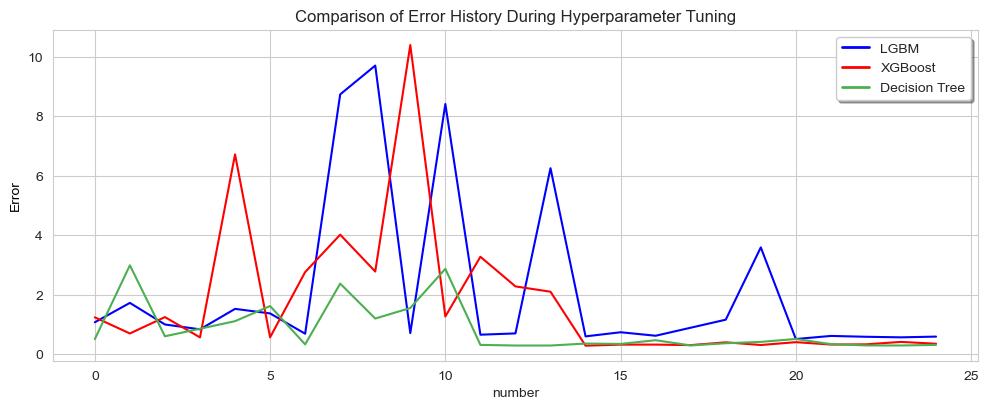

In [274]:
fig, ax1 = plt.subplots(figsize=(10,4))

sns.lineplot(data=error_SUN_LGBM_complete[:24], x="number", y="value", ax=ax1, color="blue")
sns.lineplot(data=error_SUN_XGB_complete, x="number", y="value", ax=ax1, color="red")
sns.lineplot(data=error_SUN_DecTree_complete[:24], x="number", y="value",ax=ax1, color="#4CAF50")
ax1.set_ylabel("Error", color="black")

# Add labels on the side with box
# ax1.text(0.95, 0.95, 'LGBM', verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='blue', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# ax1.text(0.95, 0.85, 'XGBoost', verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# ax1.text(0.95, 0.75, 'Decision Tree', verticalalignment='top', horizontalalignment='right', transform=ax1.transAxes, color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

ax1.set_ylabel("Error", color="black")
fig.tight_layout()

plt.title("Comparison of Error History During Hyperparameter Tuning")
# Create custom legend handles and labels
legend_handles = [
    plt.Line2D([0], [0], color='blue', lw=2),
    plt.Line2D([0], [0], color='red', lw=2),
    plt.Line2D([0], [0], color='#4CAF50', lw=2)
]

plt.legend(legend_handles, ['LGBM', 'XGBoost', 'Decision Tree'], loc='upper right', fancybox=True, shadow=True, framealpha=1, fontsize='medium')
plt.show()

#### A comparision of the training & tuning duration for each cluster between LightGBM & XGBoost

In [306]:

SUN_XGB_Reg_viz = SUN_XGB_Reg.copy()
SUN_LGBM_Reg_viz = SUN_LGBM_Reg.copy()
SUN_DecTree_Reg_viz = SUN_DecTree_Reg.copy()

SUN_LGBM_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_LGBM_Reg_viz = SUN_LGBM_Reg_viz.drop_duplicates()

SUN_XGB_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_XGB_Reg_viz = SUN_XGB_Reg_viz.drop_duplicates()

SUN_DecTree_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_DecTree_Reg_viz = SUN_DecTree_Reg_viz.drop_duplicates()

duration = pd.concat([SUN_LGBM_Reg_viz, SUN_XGB_Reg_viz, SUN_DecTree_Reg_viz])
# Convert string columns to datetime
duration['datetime_start'] = pd.to_datetime(duration['datetime_start'])
duration['datetime_complete'] = pd.to_datetime(duration['datetime_complete'])

# Calculate trial duration
duration['duration'] = duration['datetime_complete'] - duration['datetime_start']

# Group by 'study' and sum the durations
study_dur = duration.groupby('study_name')['duration'].sum()

study_dur_min = study_dur.dt.total_seconds() / 60
df = study_dur_min.reset_index()
df.columns = ["Study", "Duration (Minutes)"]

df['Model'] = df['Study'].apply(lambda x: 'LGBMRegressor' if 'LGBM' in x else ('XGBRegressor' if 'XGB' in x else 'DecisionTreeRegressor'))

color_scale = {'LGBMRegressor': 'blue', 'XGBRegressor': 'red', "DecisionTreeRegressor": "green"}

df['Shortened Study'] = df['Study'].apply(lambda x: x.split('_')[-1])

fig = px.bar(df, x='Shortened Study', y='Duration (Minutes)', color='Model',
             labels={'Duration (Minutes)': 'Duration (Minutes)', 'Color': 'Color'}, title='Duration of Studies')

# Update layout to set axis titles
fig.update_layout(xaxis_title='Study', yaxis_title='Duration (Minutes)')

# Update x-axis to hide tick labels
fig.update_xaxes(showticklabels=True)

# Show the plot
fig.show()

,trial_id,number,study_id,state,datetime_start,datetime_complete,trial_value_id,objective,value,study_name,duration
220,2078,42,23,COMPLETE,2024-03-10 20:07:53.054005,2024-03-10 20:12:30.631865,2066,0,0.471415,SUN_LGBMRegressor_unsplit_dataframe,0 days 00:04:37.577860
230,2102,23,24,COMPLETE,2024-03-10 20:47:42.011640,2024-03-10 20:49:08.418903,2090,0,0.427450,SUN_LGBMRegressor_type_D,0 days 00:01:26.407263
240,2125,21,25,COMPLETE,2024-03-10 21:01:59.421942,2024-03-10 21:02:20.232442,2113,0,0.572806,SUN_LGBMRegressor_type_B,0 days 00:00:20.810500
250,2130,1,26,COMPLETE,2024-03-10 21:04:37.724301,2024-03-10 21:05:08.860473,2118,0,0.448781,SUN_LGBMRegressor_type_C,0 days 00:00:31.136172
260,2173,19,27,COMPLETE,2024-03-10 21:32:54.913502,2024-03-10 21:33:25.822126,2161,0,0.552278,SUN_LGBMRegressor_type_E,0 days 00:00:30.908624
...,...,...,...,...,...,...,...,...,...,...,...
234,487,24,22,COMPLETE,2024-03-11 17:46:47.398246,2024-03-11 17:46:56.546449,479,0,0.206009,SUN_DecisionTreeRegressor_cluster_2,0 days 00:00:09.148203
247,501,13,23,COMPLETE,2024-03-11 17:47:54.990249,2024-03-11 17:48:01.188458,493,0,0.432278,SUN_DecisionTreeRegressor_cluster_5,0 days 00:00:06.198209
260,514,1,24,COMPLETE,2024-03-11 17:49:08.664470,2024-03-11 17:49:15.065560,506,0,0.256507,SUN_DecisionTreeRegressor_cluster_11,0 days 00:00:06.401090
273,550,12,25,COMPLETE,2024-03-11 17:55:46.008349,2024-03-11 17:56:21.347989,542,0,0.486455,SUN_DecisionTreeRegressor_cluster_14,0 days 00:00:35.339640


#### Overall Model Error comparision

In [278]:
light_gbm_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_LGBMRegressor_2024-03-11_00-06-38.parquet")
light_gbm_df.loc[light_gbm_df["LGBMRegressor"] < 0, "LGBMRegressor"] = 0
lgbm_error = mean_squared_log_error(light_gbm_df['y'], light_gbm_df["LGBMRegressor"])

xgb_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_XGBRegressor_2024-03-12_01-23-53.parquet")
xgb_df.loc[xgb_df["XGBRegressor"] < 0, "XGBRegressor"] = 0
xgb_error = mean_squared_log_error(xgb_df['y'], xgb_df["XGBRegressor"])

decision_tree_df = pd.read_parquet("C:/Users/felsp/Documents/Studium/Master/Forecasting/ForecastingUniProject/results/prediction_dfs/prediction_DecisionTreeRegressor_2024-03-11_18-04-50.parquet")
decision_tree_error = mean_squared_log_error(decision_tree_df['y'], decision_tree_df["DecisionTreeRegressor"])

error_comp = pd.DataFrame({"Model": ["LGBM", "XGB", "Decision Tree"], "Error": [lgbm_error, xgb_error, decision_tree_error]})

fig_error_comp = px.bar(error_comp, x="Model", y="Error", title="Error Comparision between LGBM, XGB and Decision Trees", color = "Model")
fig_error_comp.show()

#### Errors over each Cluster for each model

In [300]:
import plotly.graph_objects as go

# Modify the study names and add a column indicating the origin
XGB_Reg_viz = SUN_XGB_Reg.copy()
LGBM_Reg_viz = SUN_LGBM_Reg.copy()
DecTree_Reg_viz = SUN_DecTree_Reg.copy()

LGBM_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
LGBM_Reg_viz = LGBM_Reg_viz.drop_duplicates()

XGB_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
XGB_Reg_viz = XGB_Reg_viz.drop_duplicates()

DecTree_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
DecTree_Reg_viz = DecTree_Reg_viz.drop_duplicates()


XGB_Reg_viz['Origin'] = 'XGB'
LGBM_Reg_viz['Origin'] = 'LGBM'
DecTree_Reg_viz['Origin'] = 'DecisionTree'
XGB_Reg_viz['Study'] = XGB_Reg_viz['study_name'].str.split('_').str[-1]
LGBM_Reg_viz['Study'] = LGBM_Reg_viz['study_name'].str.split('_').str[-1]
DecTree_Reg_viz['Study'] = DecTree_Reg_viz['study_name'].str.split('_').str[-1]



# Create the first plot
fig_xgb = px.bar(XGB_Reg_viz, x="Study", y="value", color='Origin',
                 color_discrete_map={'XGB': 'blue'}, labels={"Study": "Study", "value": "Error"}, title='Error Plot')

# Create the second plot
fig_lgbm = px.bar(LGBM_Reg_viz, x="Study", y="value", color='Origin', 
                  color_discrete_map={'LGBM': 'red'}, labels={"Study": "Study", "value": "Error"}, title='Error Plot')

# Create the third plot
fig_decTree = px.bar(DecTree_Reg_viz, x="Study", y="value", color='Origin', 
                  color_discrete_map={'DecisionTree': 'green'}, labels={"Study": "Study", "value": "Error"}, title='Error Plot')

# Create a combined figure
combined_fig = px.bar(XGB_Reg_viz, x="Study", y="value", color='Origin', barmode= "group",
                      color_discrete_map={'XGB': 'blue', 'LGBM': 'red', 'DecisionTree': 'green'}, labels={"Study": "Study", "value": "Error"}, title='Error Plot')

# Add traces from the second plot
for trace in fig_lgbm.data:
    combined_fig.add_trace(trace)

# Add traces from the thrid plot
for trace in fig_decTree.data:
    combined_fig.add_trace(trace)

# Update layout
combined_fig.update_layout(title="Combined Error Plots",
                            xaxis_title="Cluster",
                            yaxis_title="Error")

# Show the combined plot
combined_fig.show()

#### Plot to compare Errors with Duration of each Model

In [310]:
import plotly.graph_objects as go

# Modify the study names and add a column indicating the origin
SUN_XGB_Reg_viz = SUN_XGB_Reg.copy()
SUN_LGBM_Reg_viz = SUN_LGBM_Reg.copy()
SUN_DecTree_Reg_viz = SUN_DecTree_Reg.copy()

SUN_LGBM_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_LGBM_Reg_viz = SUN_LGBM_Reg_viz.drop_duplicates()

SUN_XGB_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_XGB_Reg_viz = SUN_XGB_Reg_viz.drop_duplicates()

SUN_DecTree_Reg_viz.drop(columns={"param_id", "param_value", "param_name"}, axis=1, inplace=True)
SUN_DecTree_Reg_viz = SUN_DecTree_Reg_viz.drop_duplicates()

duration_LGBM = pd.concat([SUN_LGBM_Reg_viz, SUN_XGB_Reg_viz, SUN_DecTree_Reg_viz])
# Convert string columns to datetime
duration_LGBM['datetime_start'] = pd.to_datetime(duration_LGBM['datetime_start'])
duration_LGBM['datetime_complete'] = pd.to_datetime(duration_LGBM['datetime_complete'])

# Calculate trial duration
duration_LGBM['duration'] = duration_LGBM['datetime_complete'] - duration_LGBM['datetime_start']

# Group by 'study' and sum the durations
study_duration = duration_LGBM.groupby('study_name')['duration'].sum()

study_duration_hours = study_duration.dt.total_seconds() / 60
df = study_duration_hours.reset_index()
df.columns = ["study_name", "Duration (Minutes)"]


df['Model'] = df['study_name'].apply(lambda x: 'LGBMRegressor' if 'LGBM' in x else ('XGBRegressor' if 'XGB' in x else 'DecisionTreeRegressor'))

color_scale = {'LGBMRegressor': 'blue', 'XGBRegressor': 'red', "DecisionTreeRegressor": "green"}



df = pd.merge(df, duration_LGBM, on="study_name")
df['Shortened Study'] = df['study_name'].apply(lambda x: x.split('_')[-1])

# Create the combined figure
combined_fig = go.Figure()

# Add the error bars for each model with a darker shade
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "XGBRegressor"]["value"], name="XGB Error", marker_color='rgba(0, 0, 255, 0.7)'))
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "LGBMRegressor"]["value"], name="LGBM Error", marker_color='rgba(255, 0, 0, 0.7)'))
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "DecisionTreeRegressor"]["value"], name="DecisionTree Error", marker_color='rgba(0, 128, 0, 0.7)'))

# Add the duration bars for each model with a lighter shade
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "XGBRegressor"]["Duration (Minutes)"], name="XGB Duration", marker_color='rgba(0, 255, 255, 0.7)', yaxis='y2'))
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "LGBMRegressor"]["Duration (Minutes)"], name="LGBM Duration", marker_color='rgba(255, 255, 0, 0.7)', yaxis='y2'))
combined_fig.add_trace(go.Bar(x=df["Shortened Study"], y=df[df["Model"] == "DecisionTreeRegressor"]["Duration (Minutes)"], name="DecisionTree Duration", marker_color='rgba(255, 128, 0, 0.7)', yaxis='y2'))

# Update layout
combined_fig.update_layout(
    title="Combined Error and Duration Plots",
    xaxis=dict(title="Study"),
    yaxis=dict(title="Error"),
    yaxis2=dict(title="Duration (Minutes)", overlaying='y', side='right'),
    barmode='group'
)

# Show the combined plot
combined_fig.show()



### Der Code hier unter wird noch nicht verwendet, ist für feature_importance gedacht

In [ ]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

def month_start_or_end(dates):
    """Date is month start or month end"""
    return dates.is_month_start | dates.is_month_end

def is_saturday(dates):
    """Date is monday"""
    return dates.dayofweek == 5

def get_feature_importance(train, valid, h, config, model):
    if model == "XGBRegressor":
        models = [XGBRegressor(random_state=42,
                               n_estimators=config["n_estimators"],
                               learning_rate=config["learning_rate"],
                               max_depth=config["max_depth"],
                               colsample_bytree=config["colsample_bytree"],
                               reg_lambda=config["reg_lambda"]
                               )]
    elif model == "LGBMRegressor":
        models = [LGBMRegressor(random_state=42,
                                n_estimators=config["n_estimators"],
                                learning_rate=config["learning_rate"],
                                max_depth=config["max_depth"],
                                num_leaves=config["num_leaves"],
                                min_data_in_leaf=config["min_data_in_leaf"],
                                bagging_fractiong=config["bagging_fraction"],
                                colsample_bytree=config["colsample_bytree"],
                                lambda_l2=config["lambda_l2"],
                                verbose=-1
                                )]

    mlfc = mlforecast.MLForecast(models=models,
                    freq='D',
                    lags=[1,7,config["lags"]],
                    lag_transforms={
                        1: [(rolling_mean, 4), (rolling_min, 4), (rolling_max, 4)],
                    },
                    date_features=['week', 'month', 'dayofweek', 'dayofyear', is_saturday, month_start_or_end],
                    num_threads=8)
    
    prep_df = mlfc.preprocess(train)
    
    ml = models[0]

    ml.fit(prep_df, h)
    prediction = ml.predict(valid)

    feature_importance = ml.feature_importances_

    #merged_prediction = pd.merge(valid, prediction, on=["ds", "unique_id"], how="inner")

    #return merged_prediction
    return feature_importance

What to do next:

- Analyse verschiedener Modelle
- Guten plot einbauen der forecast zeigt
- Cross Validation einbauen
- Feature Importance einbauen
- Future Leakage Fix einbauen

Ideen für Feature Importance:
- Datensatz mit mlfc.preprocess(train) nur vorbereiten, nicht trainieren oder predicten
- Datensatz anschauen und überprüfen ob wie erwartet
- Datensatz direkt in LightGBM geben und da trainieren und predicten
- Prediction results mit Erwarteten Wert von MLForecast Training vergleichen
- Wenn gleich, dann lgb.plot_importance() machen und anschauen
- Am besten wäre es, wenn wir an die Daten direkt tabelarisch rankommen würden anstatt nur nen plot zu kriegen, damit wir selbst wieder One-Hot-Encodete features aufsummieren können
- Sowohl gain als auch split mal anschauen
- Gleiches für XGBoost einrichten

Idee für Plot:
- Daten für ein paar unique_ids rausfiltern
- Diese daten dann als Lineplot für y plotten
- Darüber dann die prediction legen

Idee für cross validation:
- Idk, einfach versuchen das iwi mit mlforecast cross validator durchzuboxen